In [1]:
!pip install bertviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.5/157.5 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [66]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import transformers
import accelerate
from datasets import DatasetDict, Dataset
import bertviz
import umap
from transformers import AutoModel
import torch
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [3]:
data_t = pd.read_csv("/content/drive/MyDrive/fine-tune Beart/twitter_multi_class_sentiment.csv")

In [4]:
data_t.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [5]:
data_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        16000 non-null  object
 1   label       16000 non-null  int64 
 2   label_name  16000 non-null  object
dtypes: int64(1), object(2)
memory usage: 375.1+ KB


In [6]:
data_t.describe()

,label
count,16000.000000
mean,1.565937
std,1.501430
min,0.000000
25%,0.000000
50%,1.000000
75%,3.000000
max,5.000000


In [7]:
data_t["label_name"].unique()

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

In [8]:
data_t["text"][23]

'i was able to help chai lifeline with your support and encouragement is a great feeling and i am so glad you were able to help me'

# Dataset Analysis

In [9]:
data_t["words_per_tweet "] = data_t["text"].str.split().apply(len)
data_t


,text,label,label_name,words_per_tweet
0,i didnt feel humiliated,0,sadness,4
1,i can go from feeling so hopeless to so damned...,0,sadness,21
2,im grabbing a minute to post i feel greedy wrong,3,anger,10
3,i am ever feeling nostalgic about the fireplac...,2,love,18
4,i am feeling grouchy,3,anger,4
...,...,...,...,...
15995,i just had a very brief time in the beanbag an...,0,sadness,24
15996,i am now turning and i feel pathetic that i am...,0,sadness,20
15997,i feel strong and good overall,1,joy,6
15998,i feel like this was such a rude comment and i...,3,anger,14


In [10]:
print(data_t["words_per_tweet "].max())
print(data_t["words_per_tweet "].argmax())


66
6322


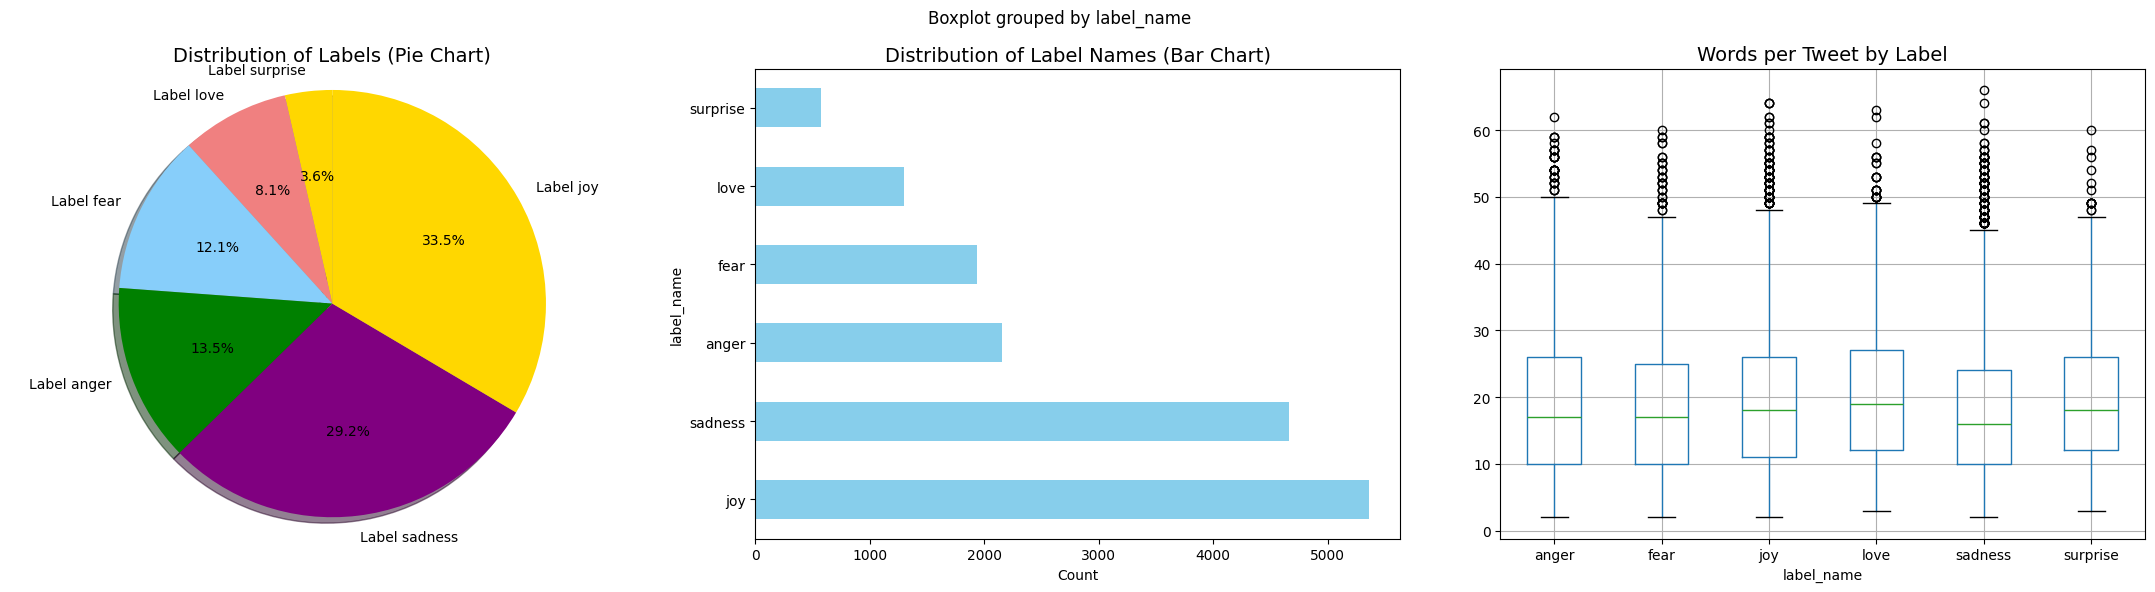

In [11]:
fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(22, 6))

label_counts = data_t['label_name'].value_counts(ascending=True)
label_percentages = (label_counts / len(data_t)) * 100
colors = ['gold', 'lightcoral', 'lightskyblue', 'green', 'purple']

ax1.pie(
    label_percentages,
    labels=[f'Label {i}' for i in label_percentages.index],
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    shadow=True
)
ax1.set_title('Distribution of Labels (Pie Chart)', fontsize=14)
ax1.axis('equal')


label_name_counts = data_t['label_name'].value_counts()
label_name_counts.plot.barh(ax=ax2, color='skyblue')
ax2.set_title('Distribution of Label Names (Bar Chart)', fontsize=14)
ax2.set_xlabel('Count')


data_t.boxplot("words_per_tweet ",by = "label_name",ax= ax3 )
ax3.set_title('Words per Tweet by Label', fontsize=14)

plt.tight_layout()
plt.show()

# Model

In [12]:
model_name = "bert-base-uncased"

In [13]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [14]:
text = "hi my name is Milad"

In [15]:
tokenizer(text)

{'input_ids': [101, 7632, 2026, 2171, 2003, 23689, 4215, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

In [16]:
tokenizer.vocab

{'webb': 10923,
 'anyone': 3087,
 'interruption': 24191,
 'mechanized': 23387,
 'genre': 6907,
 'mysore': 20761,
 'propaganda': 10398,
 'hindu': 7560,
 'success': 3112,
 'kelley': 19543,
 '##wa': 4213,
 '-': 1011,
 '207': 19843,
 'redevelopment': 15582,
 'lash': 25210,
 'starboard': 25211,
 'prizes': 11580,
 'patel': 20455,
 'auf': 21200,
 '##rite': 17625,
 '[unused267]': 272,
 'quote': 14686,
 'preschool': 23655,
 'antibody': 27781,
 'disaster': 7071,
 'reacts': 27325,
 '##ら': 30211,
 'trick': 7577,
 'shrimp': 20130,
 'ruined': 9868,
 '##33': 22394,
 'rotor': 18929,
 'seeking': 6224,
 '1659': 28288,
 '##ա': 29766,
 'observes': 24451,
 'tiny': 4714,
 'literal': 18204,
 '[unused711]': 716,
 '[unused3]': 4,
 '##լ': 29773,
 'societies': 8384,
 'georgian': 9166,
 'contradictory': 27894,
 '##hing': 12053,
 'inched': 25330,
 '##oping': 17686,
 '##won': 19291,
 'garner': 18661,
 'resulted': 4504,
 'dot': 11089,
 'abandoning': 19816,
 '##nad': 25389,
 'napoleonic': 18813,
 'surroundings': 1130

In [17]:
len(tokenizer.vocab) , tokenizer.vocab_size,tokenizer.model_max_length,tokenizer.model_input_names

(30522, 30522, 512, ['input_ids', 'token_type_ids', 'attention_mask'])

In [18]:
tokenizer("fleet")

{'input_ids': [101, 4170, 102], 'token_type_ids': [0, 0, 0], 'attention_mask': [1, 1, 1]}

# Data Loder

In [19]:
train, test = train_test_split(data_t,test_size=0.3,stratify=data_t["label_name"])
test,valid = train_test_split(test,test_size=1/3,stratify=test["label_name"])

In [20]:
train.shape , test.shape , valid.shape

((11200, 4), (3200, 4), (1600, 4))

In [21]:
dataset = DatasetDict(
    {"train" :Dataset.from_pandas(train,preserve_index=False) ,
     "test": Dataset.from_pandas(test,preserve_index=False),
     "valid":Dataset.from_pandas(valid,preserve_index=False)}
)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name', 'words_per_tweet '],
        num_rows: 11200
    })
    test: Dataset({
        features: ['text', 'label', 'label_name', 'words_per_tweet '],
        num_rows: 3200
    })
    valid: Dataset({
        features: ['text', 'label', 'label_name', 'words_per_tweet '],
        num_rows: 1600
    })
})

# Tokenization of the Sentiment Data

In [22]:
dataset["train"][0]

{'text': 'i feel humiliated to introduce you to my colleagues as my wife',
 'label': 0,
 'label_name': 'sadness',
 'words_per_tweet ': 12}

In [23]:
def tokenize(batvh):
  temp = tokenizer(batvh['text'],padding=True,truncation=True)
  return temp


In [24]:
tokenize(dataset["train"][0:2])

{'input_ids': [[101, 1045, 2514, 26608, 2000, 8970, 2017, 2000, 2026, 8628, 2004, 2026, 2564, 102], [101, 1045, 2001, 3110, 15560, 1998, 3621, 6314, 2044, 2023, 4512, 102, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]]}

In [25]:
emotion_encoded = dataset.map(tokenize,batched=True,batch_size=None)

Map:   0%|          | 0/11200 [00:00<?, ? examples/s]

Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

In [26]:
emotion_encoded["train"][0]

{'text': 'i feel humiliated to introduce you to my colleagues as my wife',
 'label': 0,
 'label_name': 'sadness',
 'words_per_tweet ': 12,
 'input_ids': [101,
  1045,
  2514,
  26608,
  2000,
  8970,
  2017,
  2000,
  2026,
  8628,
  2004,
  2026,
  2564,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'token_type_ids': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0

In [27]:
label2id = {x["label_name"]:x["label"]for x in dataset["train"]}
id2label = {v:k for k,v in label2id.items()}
print("id2label : ",id2label),print("label2id : ",label2id)

id2label :  {0: 'sadness', 3: 'anger', 4: 'fear', 2: 'love', 1: 'joy', 5: 'surprise'}
label2id :  {'sadness': 0, 'anger': 3, 'fear': 4, 'love': 2, 'joy': 1, 'surprise': 5}


(None, None)

# Model building


In [28]:
model =  AutoModel.from_pretrained(model_name)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [29]:
model.config

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.53.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [30]:
from transformers import AutoModelForSequenceClassification,AutoConfig

In [31]:
num_labels = len(id2label)
devise = torch.device("cuda" if torch.cuda.is_available() else "cpu")
devise

device(type='cuda')

In [32]:
config = AutoConfig.from_pretrained(model_name,label2id = label2id, id2label = id2label)
config

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "sadness",
    "1": "joy",
    "2": "love",
    "3": "anger",
    "4": "fear",
    "5": "surprise"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "anger": 3,
    "fear": 4,
    "joy": 1,
    "love": 2,
    "sadness": 0,
    "surprise": 5
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.53.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [33]:
model = AutoModelForSequenceClassification.from_pretrained(model_name,config = config).to(devise)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [36]:
from transformers import TrainingArguments

batch_size  = 64
training_dir ="bert_base_train_dir"

# training_args = TrainingArguments(output_dir=training_dir,
#                                   overwrite_output_dir= True,
#                                   num_train_epochs=2,
#                                   learning_rate= 2e-5,
#                                   per_device_train_batch_size = batch_size ,
#                                   per_device_eval_batch_size= batch_size ,
#                                   weight_decay=0.01,
#                                   disable_tqdm = False,
#                                   eval_strategy = "epoch"

# )
training_args = TrainingArguments(
    output_dir="bert_base_train_dir",
    run_name="bert-finetuning-epochs2-lr2e-5",
    overwrite_output_dir=True,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    eval_strategy="epoch",
    report_to="none",
)

### Build compute metrics function

In [37]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.8 MB/s eta 0:00:00


In [38]:
import evaluate
accuracy = evaluate.load("accuracy")

In [39]:
# Method 1

import numpy as np


def compute_metrics_evaluate(eval_pred):
  predictions,labels = eval_pred
  predictions = np.argmax(predictions,axis=1)
  return  accuracy.compute(predictions=predictions,references=labels)



In [40]:
# Method 2
from sklearn.metrics import accuracy_score,f1_score

def compute_metrics(pred):
   labels = pred.label_ids
   preds = pred.predictions.argmax(-1)

   f1 = f1_score(labels,preds,average="weighted")
   acc = accuracy_score(labels,preds)

   return {"accuracy" : acc,"f1" : f1}

## Build Model and Trainer

In [41]:
from transformers import Trainer


trainer = Trainer(model = model,args =  training_args,
                  compute_metrics = compute_metrics,
                  train_dataset= emotion_encoded["train"],
                  eval_dataset= emotion_encoded["valid"],
                  tokenizer = tokenizer
                  )

/tmp/ipython-input-41-1498123257.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model = model,args =  training_args,


In [43]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.422224,0.851875,0.833405
2,No log,0.262722,0.911250,0.910226


TrainOutput(global_step=350, training_loss=0.6320675659179688, metrics={'train_runtime': 337.8985, 'train_samples_per_second': 66.292, 'train_steps_per_second': 1.036, 'total_flos': 1015809598967040.0, 'train_loss': 0.6320675659179688, 'epoch': 2.0})

# Model Evaluation

In [44]:
preds_out = trainer.predict(emotion_encoded["test"])
preds_out.metrics

{'test_loss': 0.27882277965545654,
 'test_accuracy': 0.91,
 'test_f1': 0.9092564468753614,
 'test_runtime': 17.0503,
 'test_samples_per_second': 187.679,
 'test_steps_per_second': 23.46}

In [53]:
y_pred = np.argmax(preds_out.predictions,axis = 1)
y_true = emotion_encoded["test"][:]["label"]

In [57]:
y_pred

array([1, 1, 1, ..., 1, 1, 0])

In [55]:
print(y_true)

[1, 1, 1, 1, 0, 2, 4, 3, 2, 1, 0, 1, 1, 1, 3, 0, 3, 1, 3, 1, 0, 4, 1, 1, 1, 1, 4, 0, 1, 1, 0, 3, 1, 0, 1, 1, 3, 3, 0, 4, 1, 0, 0, 0, 3, 1, 2, 1, 1, 1, 2, 1, 3, 3, 0, 1, 3, 2, 1, 1, 1, 0, 0, 3, 4, 4, 4, 2, 3, 1, 1, 3, 2, 0, 4, 2, 3, 2, 3, 0, 0, 1, 3, 1, 0, 1, 5, 1, 0, 1, 0, 1, 2, 0, 0, 0, 1, 3, 2, 1, 0, 1, 2, 2, 3, 0, 5, 3, 2, 1, 1, 0, 4, 0, 1, 4, 4, 2, 3, 5, 1, 1, 3, 1, 1, 1, 1, 3, 4, 1, 4, 4, 3, 1, 2, 4, 1, 1, 0, 0, 1, 4, 0, 3, 4, 1, 0, 0, 0, 3, 3, 1, 0, 0, 0, 1, 1, 1, 2, 3, 1, 3, 4, 1, 3, 0, 2, 4, 1, 0, 4, 2, 0, 0, 3, 1, 5, 1, 1, 1, 2, 0, 4, 3, 0, 2, 0, 1, 1, 2, 1, 0, 3, 3, 4, 1, 4, 2, 4, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 4, 3, 0, 4, 0, 4, 0, 5, 0, 1, 3, 1, 4, 1, 0, 1, 0, 0, 0, 0, 0, 0, 3, 1, 2, 2, 0, 1, 1, 0, 1, 2, 1, 1, 1, 4, 1, 0, 3, 3, 3, 1, 2, 0, 1, 1, 1, 4, 4, 3, 4, 0, 1, 0, 0, 3, 1, 0, 1, 1, 4, 0, 0, 1, 0, 2, 4, 1, 3, 4, 1, 1, 3, 1, 3, 2, 0, 4, 0, 5, 3, 5, 3, 3, 2, 0, 4, 3, 1, 0, 1, 2, 4, 1, 0, 1, 0, 4, 3, 4, 4, 1, 2, 0, 3, 4, 0, 1, 1, 1, 0, 4, 4, 1, 1, 1, 2, 0, 4, 2, 2, 1, 1, 2, 

In [65]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       933
           1       0.93      0.93      0.93      1072
           2       0.82      0.79      0.80       261
           3       0.90      0.91      0.91       432
           4       0.86      0.89      0.88       387
           5       0.87      0.69      0.77       115

    accuracy                           0.91      3200
   macro avg       0.89      0.86      0.87      3200
weighted avg       0.91      0.91      0.91      3200



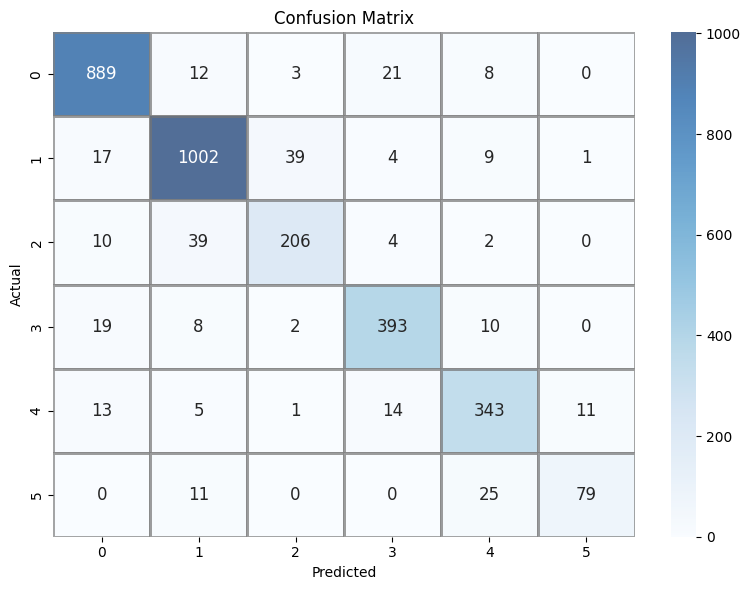

In [69]:
# Generate confusion matrix for classes 0-5
cm = confusion_matrix(y_true, y_pred, labels=np.arange(6))

# Set up plot
plt.figure(figsize=(8, 6))
ax = sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    alpha=0.7,
    linewidths=1,
    linecolor='gray',
    annot_kws={'size': 12}
)

# Add labels and formatting
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
ax.set_xticks(np.arange(6) + 0.5)
ax.set_yticks(np.arange(6) + 0.5)
ax.set_xticklabels(np.arange(6))
ax.set_yticklabels(np.arange(6))

plt.tight_layout()
plt.show()

# Build Prediction Function and Store Model

   "0": "sadness",
    "1": "joy",
    "2": "love",
    "3": "anger",
    "4": "fear",
    "5": "surprise"

In [70]:
exam_text = "Hi my name is Milad,Today I am incredibly happy.because I readed a book"

In [71]:
input_encoded = tokenizer(exam_text,return_tensors="pt").to(devise)

In [72]:
input_encoded

{'input_ids': tensor([[  101,  7632,  2026,  2171,  2003, 23689,  4215,  1010,  2651,  1045,
          2572, 11757,  3407,  1012,  2138,  1045,  3191,  2098,  1037,  2338,
           102]], device='cuda:0'), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0')}

In [87]:
def get_pred(test):
  input_encoded = tokenizer(exam_text,return_tensors="pt").to(devise)
  with torch.no_grad():
    outs = model(**input_encoded)

  logits = outs.logits
  pred = torch.argmax(logits,dim = 1).item()
  return pred,id2label[pred]

In [88]:
get_pred(exam_text)

(1, 'joy')

## Save Model

In [90]:
trainer.save_model("/content/drive/MyDrive/fine-tune Beart/twitter_sentiment_bert")

### Pipeline


In [92]:
from transformers import pipeline

classifier = pipeline("text-classification",model = "twitter_sentiment_bert")

Device set to use cuda:0


In [93]:
classifier(exam_text)

[{'label': 'joy', 'score': 0.9615863561630249}]